# Semantic Segmentation

Semantic segmentation is a computer vision task that involves assigning a label to each pixel in an image, with the goal of segmenting the image into meaningful regions. It is a fundamental problem in understanding and analyzing images, with applications in various fields such as autonomous driving, medical imaging, and scene understanding.

The input to the network had to be rescaled because of the memory and GPU hours limitations from (256, 256,3) to (128,128, 3). Notebook with scores and plots for full input size was calculated too, and can be found here https://github.com/mlewandowski0/SemanticSegmentation.

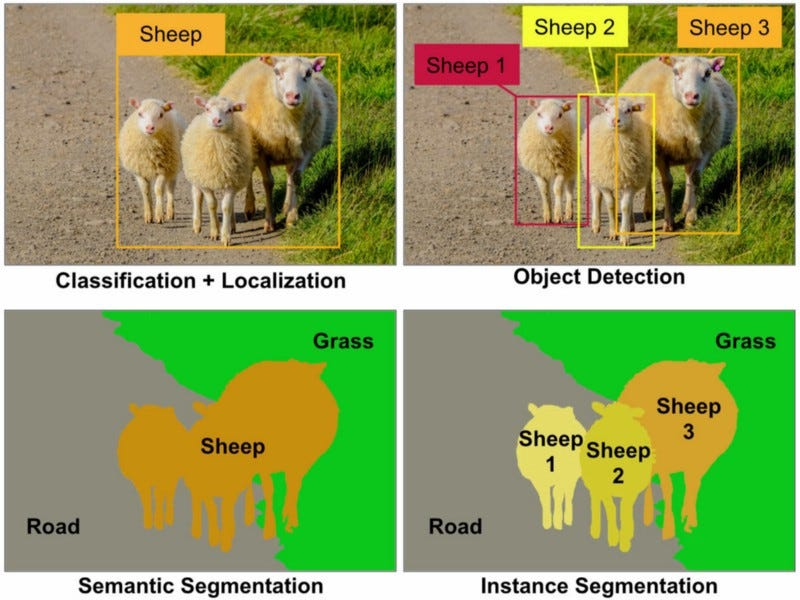

In this tutorial, we'll cover the following steps to build a semantic segmentation model using PyTorch:
1. Dataset Preparation and visualization
2. Discussion on evaluation metrics
3. Writing evaluation and training methods
4. Model definition and training
5. Inference on New Images
6. Effect of different loss functions

## Imports
We start by installing extra dependencies and importing relevant libraries

In [3]:
# Install extra dependencies
!pip install -q torchinfo accelerate tqdm

import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra

# pytorch dependency
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch import Tensor

# HuggingFace accelerate library
from accelerate import Accelerator # (easy support for multiple GPU's, TPU, floating point 16s, which makes training much faster)

# displaying the pytorch architecture (makes prototyping the network easier, as it shows shapes)
from torchinfo import summary

# plotting the results
import matplotlib.pyplot as plt
import seaborn as sns 

# creatation and transformations for the dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image

from collections import defaultdict

from IPython.display import clear_output

# show nice progress bar
from tqdm.auto import tqdm

from time import time

## Config
Let us now define some hyperparameters and global variables in a configuration file

In [5]:
class CONFIG:
    # use the 16 bit floating point arithmetic (should speeds up training/inference)
    USE_MIXED_PRECISION = "fp16"    # other values possible, "fp16" or None

    # downscaling the images : to make the inference on kaggle faster and keep within reason on GPU there, 
    #                          I set it to 2 (so the image is scaled from (256,256) to (128, 128)), None 
    #                          keeps the original shape 
    DOWNSCALE = 2

    # Imagenet channelwise mean
    MEAN = [0.485, 0.456, 0.406]

    # imagenet, channelwise standard deviation
    STD = [0.229, 0.224, 0.225]

    # epsilon for DICE, IoU losses (now 1e-6, however in some papers set to 1)
    EXTRA_LOSS_EPS = 1e-6

    # style of plots, I find darkgrid nice for regular plots
    SNS_STYLE = "darkgrid"

    BATCH_SIZE = 8

    SINGLE_NETWORK_TRAINING_EPOCHS = 15

    CE_VS_DICE_EVAL_EPOCHS = 15

    DELTA_BETA = 0.2

cfg = CONFIG()    

## 1. Dataset - CityScapes Image Pairs

### Context
Cityscapes data [(dataset home page)](https://www.cityscapes-dataset.com/) contains labeled videos taken from vehicles driven in Germany. This version is a processed subsample created as part of the [Pix2Pix paper](https://phillipi.github.io/pix2pix/). The dataset has still images from the original videos, and the semantic segmentation labels are shown in images alongside the original image. 

### Content
This dataset has 2975 training images files and 500 validation image files. Each image file is 256x512 pixels, and each file is a composite with the original photo on the left half of the image, alongside the labeled image (output of semantic segmentation) on the right half.

In [6]:
datapath = os.path.join("/kaggle", "input", "cityscapes-image-pairs", "cityscapes_data")

# setting up the datapaths
train_datapath = os.path.join(datapath, "train")
val_datapath = os.path.join(datapath, "val")
train_cs_datapath = os.path.join(datapath, "cityscapes_data", "train")
val_cs_datapath = os.path.join(datapath, "cityscapes_data", "val")

# list all, full datapaths for training and validation images and save them in these two variables
training_images_paths = [os.path.join(train_datapath, f) for f in os.listdir(train_datapath)]
validation_images_paths = [os.path.join(val_datapath, f) for f in os.listdir(val_datapath)]

# sanity check, how many images
print(f"size of training : {len(training_images_paths)}")
print(f"size of cityscapes training : {len(os.listdir(train_cs_datapath))}")
print(f"size of validation : {len(validation_images_paths)}")
print(f"size of cityscapes validation : {len(os.listdir(val_cs_datapath))}")

global_step = 0

size of training : 2975
size of cityscapes training : 2975
size of validation : 500
size of cityscapes validation : 500


In [7]:
# Create a HuggingFace Accelerate accelerator. This allows using multiple GPUs, TPUs or 
# mixed precision (like brain-float16 or 16bit floating points) which should make training/inference 
# faster
if cfg.USE_MIXED_PRECISION is not None:
    accelerator = Accelerator(mixed_precision=cfg.USE_MIXED_PRECISION)
else:
    accelerator = Accelerator()

### Data visualization
Firstly, inspect the dataset to see what the data looks like. Below few random images from the dataset are plotted <br>
Unfortunately in this dataset, we are not provided with separate mask data, but data is a single image which is a concatenation of input image and RGB mask representation. This makes it trickier to work with

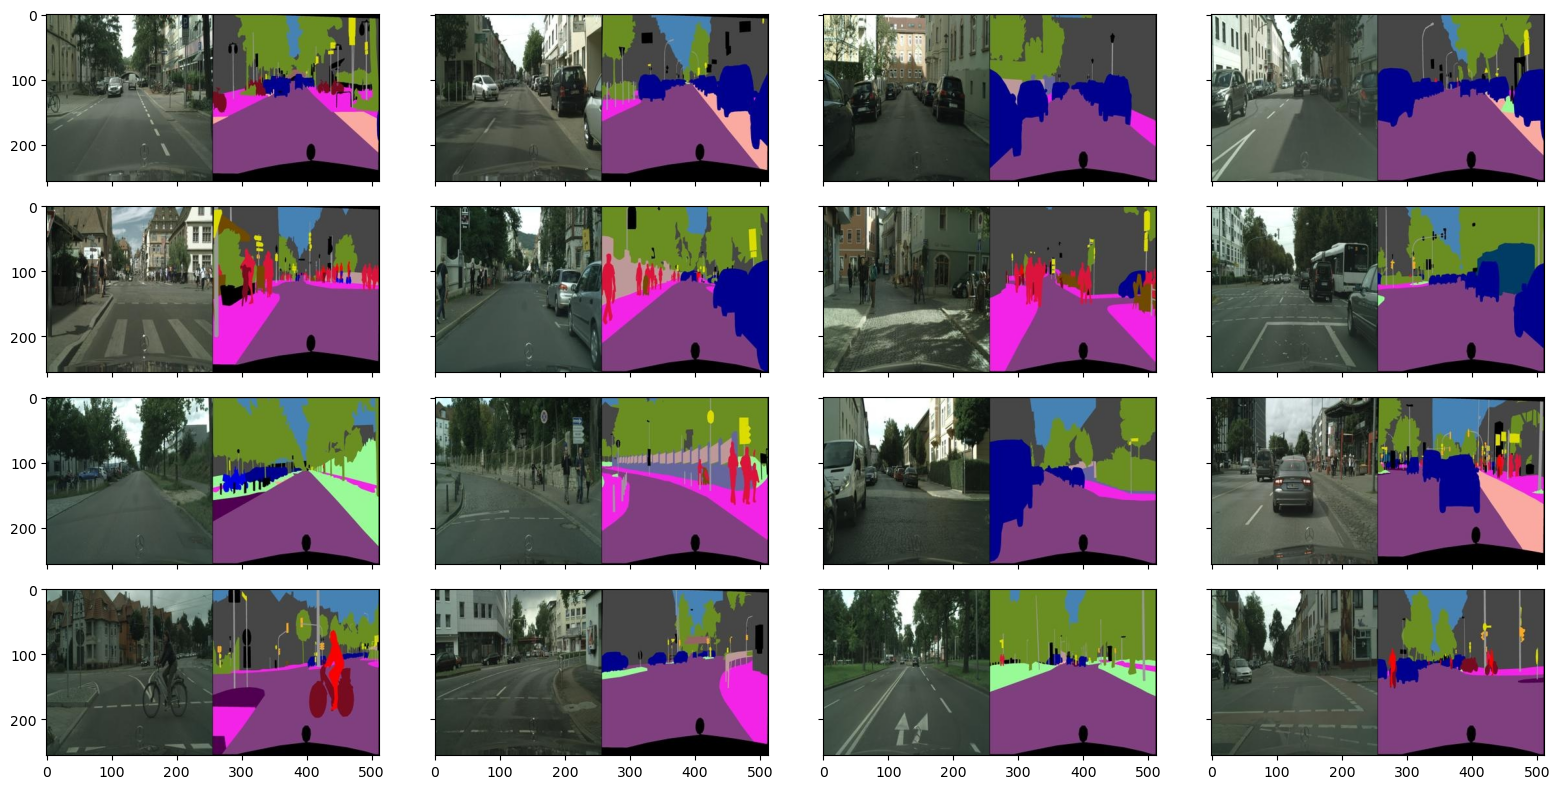

In [8]:
# how many images (total width * height)
width = 4
height = 4
vis_batch_size = width * height

# get vis_batch_size unique, random indices
indexes = np.arange(len(training_images_paths))
indexes = np.random.permutation(indexes)[:vis_batch_size]

# create the plot 
fig, axs = plt.subplots(height, width, sharex=True, sharey=True, figsize=(16, 8))
for i in range(vis_batch_size):
    # read the image
    img = torchvision.io.read_image(training_images_paths[indexes[i]])

    # pytorch reads it as (c, h, w), reshape it to (h, w, c) which is the shape matplotlib wants
    img = img.permute(1, 2, 0)
    
    # calculate the indexes for plots and set the image data
    y, x = i // width, i % width
    axs[y, x].imshow(img.numpy())
    
plt.tight_layout()

### Data preprocessing
#### labels 
To restore the categories information from a single jpg image, we firstly get the names and categories from the cited cityscapes repository. We get the color representation of each of these classes, and save it to *idx_to_color*. For each pixel then of an input jpg image, we find a closest color, and put there the index of category which represent this color. this will give us the required (height, width, num_of_classes) representation.

This is achieved by code below

In [10]:
# reference
# link : https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
idx_to_name = [ 'unlabeled','ego vehicle','rectification border', 'out of roi', 'static', 'dynamic','ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence','guard rail' , 'bridge','tunnel','pole', 'polegroup', 'traffic light', 'traffic sign' ,'vegetation', 'terrain', 'sky' ,'person', 'rider', 'car','truck' ,'bus', 'caravan','trailer', 'train' , 'motorcycle','bicycle','license plate']
idx_to_category = ["void", "flat", "construction", "object", "nature", "sky", "human", "vehicle"]

idx_to_color = [[ 0,  0,  0], [ 0,  0,  0], [  0,  0,  0], [  0,  0,  0],[ 0,  0,  0],[111, 74,  0],[81,  0, 81] ,[128, 64,128],[244, 35,232],
                [250,170,160],[230,150,140],[70, 70, 70],[102,102,156],[190,153,153],[180,165,180],[150,100,100],[150,120, 90],[153,153,153],
                [153,153,153],[250,170, 30],[220,220,  0],[107,142, 35],[152,251,152],[ 70,130,180],[220, 20, 60],[255,  0,  0],[ 0,  0,142],
                [ 0,  0, 70],[ 0, 60,100],[ 0,  0, 90],[  0,  0,110],[ 0, 80,100],[  0,  0,230],[119, 11, 32],[  0,  0,142]]


idx_to_color_np = np.array(idx_to_color)

name_to_category = {0 : 0, 1 : 0, 2 : 0, 3: 0, 4 : 0, 5 : 0, 6 : 0, 7 : 1, 8 : 1, 9 : 1, 10 : 1, 11 :2, 12 : 2, 13 : 2, 14 : 2, 15 : 2, 16 : 2,
                    17 : 3, 18 : 3, 19 : 3, 20: 3, 21 : 4, 22 : 4, 23 : 5, 24 : 6, 25 : 6, 26 : 7, 27 : 7, 28 : 7, 29 : 7, 30 : 7, 31 : 7, 32: 7, 33 : 7, 34 : 7}

size of input :  (256, 256, 3)
size of mask raw :  (256, 256, 3)
size of classes :  (256, 256)


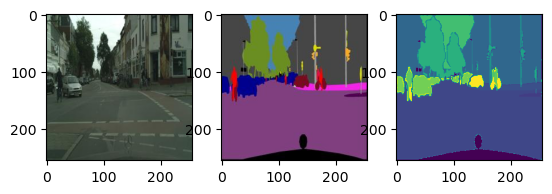

In [11]:
from typing import Tuple

# vectorize the operation of getting the name to category for numpy (just a lookup in name_to_category dictionary)
name_to_category_mapping = lambda x: name_to_category[x]
vectorized_cat_mapping = np.vectorize(name_to_category_mapping)

# vectorize the operation of mapping the name to color for numpy (just a lookup in idx_to_color dictionary)
name_to_col_mapping = lambda x: idx_to_color[x]
vectorized_col_mapping = np.vectorize(name_to_col_mapping)

def preprocess_image(path : str, sparse_mapping=True, downscale_factor=None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
        Read the .jpeg image from *path*. Return the input image (256 x 256 x 3), mask (256 x 256 x 3) read from the jpeg 
        and conversion to categories or names (if sparse_mapping is true) representation (256 x 256 x (|categories| or |names|) )
    """
    # Read the image from path and dowscale if downscale_factor is not None.
    img = Image.open(path)
    width, height = img.size

    if downscale_factor:
        width, height = width // downscale_factor, height//downscale_factor 
        img = img.resize(( width, height ))

    # then split the image into two images (in the middle of width) : input image and color mask (each represented by 3 channels)
    img = np.asarray(img)
    raw, mask = img[:, :width//2, :], img[:, width//2:, :]
    
    height, width, channels = mask.shape

    # compute then the sum of squared distances for each pixel to the colors (L2 between the color and pixel data) : 
    # the value which will be the minimal is the category name we will use for that pixel, and we will get it using argmin
    distances = np.sum((mask.reshape(-1, channels)[:, np.newaxis, :] - idx_to_color_np)**2, axis=2)
    classes = np.argmin(distances, axis=1).reshape(height, width)

    # if we want to operate on names, map the categories to names
    if sparse_mapping:
        classes = vectorized_cat_mapping(classes)
    
    return raw, mask, classes


x, mask_raw, classes = preprocess_image(training_images_paths[indexes[i]], sparse_mapping=False, downscale_factor=None)

# sanity checks and print the data
print("size of input : ", x.shape)
print("size of mask raw : ", mask_raw.shape)
print("size of classes : ", classes.shape)
plt.subplot(1, 3, 1)
plt.imshow(x)
plt.subplot(1, 3, 2)
plt.imshow(mask_raw)
plt.subplot(1, 3, 3)
plt.imshow(classes)
plt.show()

#### Load data and Pytorch dataset
In the section below, we will create and check the Pytorch dataset for this images 

##### Load dataset
There aren't that many images for training/validation and the size of them is pretty small, therefore to speed up the computation, we can
just load them into RAM. This will be achieved by preprocessing as above all paths, and appending the input images and proper masks to python arrays <br><br>
The images themselves are scaled to [0, 1] and converted to PyTorch Tensors (with the (c, h, w) convention )

In [12]:
train_images_to_use = -1

# for kaggle
downscale_factor=cfg.DOWNSCALE

X_train, Y_train = [], []
X_val, Y_val = [], []

for path in tqdm(training_images_paths[:]):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_train.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_train.append(torch.Tensor(Y))

for path in tqdm(validation_images_paths):
    X, _, Y = preprocess_image(path, downscale_factor=downscale_factor)
    X_val.append(torch.Tensor(X / 255.).permute(2, 0, 1))
    Y_val.append(torch.Tensor(Y))

  0%|          | 0/2975 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
print(f"size of X_train : {len(X_train)} ; Y_train {len(Y_train)}")
print(f"size of X_val : {len(X_val)} ; Y_val {len(Y_val)}")

size of X_train : 2975 ; Y_train 2975
size of X_val : 500 ; Y_val 500


In [16]:
total_size_in_B = 0

for i in range(len(X_train)):
    total_size_in_B += X_train[i].element_size() * X_train[i].nelement()
    total_size_in_B += Y_train[i].element_size() * Y_train[i].nelement()

for i in range(len(X_val)):
    total_size_in_B += X_val[i].element_size() * X_val[i].nelement()
    total_size_in_B += Y_val[i].element_size() * Y_val[i].nelement()

print(f"The total size of data in RAM is {round(total_size_in_B / 1000 / 1000 / 1000, 3)} GB")

The total size of data in RAM is 0.911 GB


#### Pytorch Dataset

Create a PyTorch dataset from which we will get the data. It's very simple, just get the image from the python arrays, and apply some preprocessing.<br>
Here only the normalization with $\mu$ and $\sigma$ calculated from ImageNet is applied. It could be done in loop above, however I used transforms just to keep code somehow more maintanable (and the resulting speed benefit is very small)

In [17]:
# Pytorch Dataset
class CityScapesDataset(Dataset):
    def __init__(self, X, Y, transform=None, target_transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x , y
    
    
# just normalize the data
preprocess = transforms.Compose([
    transforms.Normalize(mean=cfg.MEAN, std=cfg.STD),
])

# create the Datasets
train_ds = CityScapesDataset(X_train, Y_train, transform=preprocess)
val_ds = CityScapesDataset(X_val, Y_val, transform=preprocess)

# create the dataloaders
train_dataloader = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=True)

#### Test dataset
Just a sanity check whether the data is loaded correctly. Some artifacts are visible, like in image below. I believe this is fine, given it's only a notebook for fun and playing with some basic dataset (this wouldn't be like this if we have a mask data)

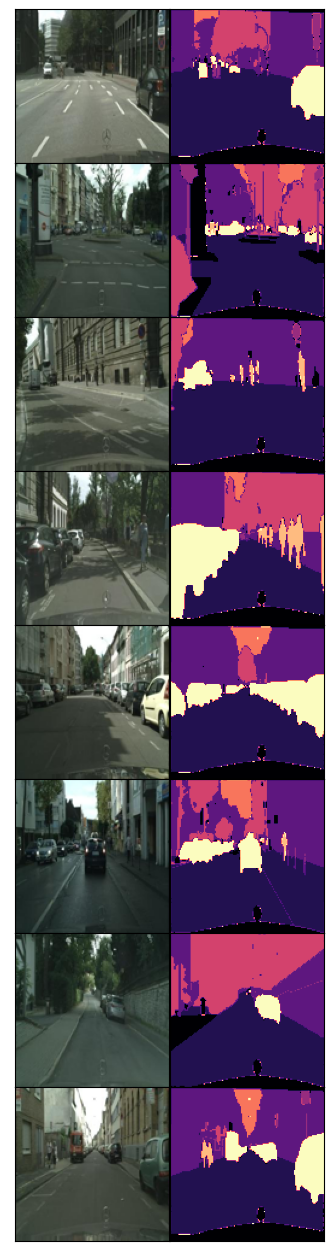

In [18]:
fig, axes = plt.subplots(cfg.BATCH_SIZE, 2, figsize=(4, 2.*cfg.BATCH_SIZE), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(cfg.BATCH_SIZE):
    img, mask = X_train[i], Y_train[i]  
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(img.permute(1,2, 0))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    axes[i, 1].imshow(mask, cmap='magma')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

#### Save a batch from test dataloader for later evaluation

torch.Size([8, 3, 128, 128]) torch.Size([8, 128, 128])


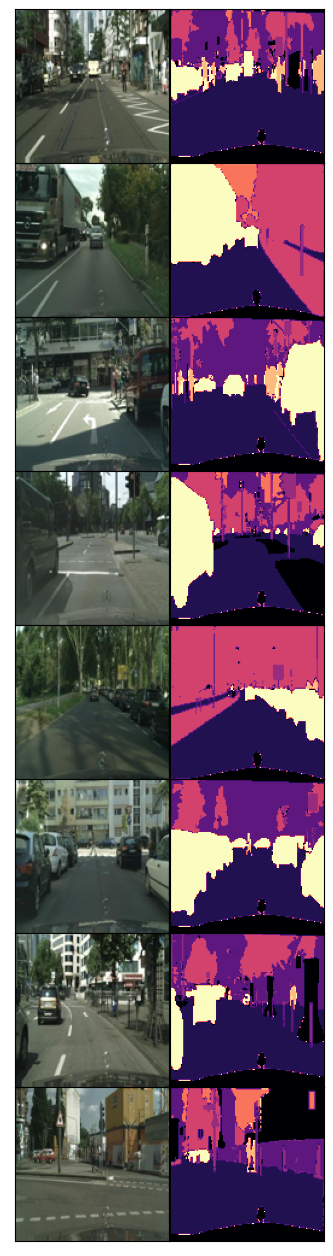

In [19]:
eval_batch_data = next(iter(val_dataloader))

# the images coming from the dataset are now preprocessed : 
# images are normalized using means and standard deviations coming from ImageNet (x' = (x - \mu) / \std)
# to decode, multiply by standard deviation, and add mean (x = x' * \std + \mu)

def decode_image(img : torch.Tensor) -> torch.Tensor:
    return img * torch.Tensor(cfg.STD) + torch.Tensor(cfg.MEAN)

print(eval_batch_data[0].shape, eval_batch_data[1].shape)
batch_size = eval_batch_data[0].shape[0]
fig, axes = plt.subplots(batch_size, 2, figsize=(4, 2.*batch_size), squeeze=True)
fig.subplots_adjust(hspace=0.0, wspace=0.0)

for i in range(batch_size):
    img, mask = eval_batch_data[0][i], eval_batch_data[1][i]  
    #print(img.shape, mask.shape)
    axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    
    axes[i, 1].imshow(mask, cmap='magma')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])

## 2. Extra Losses

### Brief Description
Because our task is pixelwise classification, initially we could think that we could just use crossentropy to predict the class of the pixel. This is used, however there exists also many other losses, which are often either used or combined, to get much better results. <br>
Other popular metrics include : 
- **DICE coefficient (or Sørensen–Dice coefficient)**. This loss is used to compare the pixelwise agreement between the predicted segmentation and mask, and is represented as : $$ DICE(X, X_{truth}) = \frac{2|X \cap X_{truth}|}{|X| + |X_{truth}|}$$ This metrics takes values from 0 (no overlap at all) and 1 (full overlap). This loss his widely adapted to calculate the simillarity of two images [2]. DICE loss has a large benefit in comparison to cross entropy, that it considers the loss information both locally and globally (in comparison to crossentropy which cares only about local). It is consider much better loss for semantic segmenation, especially in inbalanced classes problems. <br><br>
- **Intersection over Union (or Jaccard coefficient)**. Simillarly to DICE, This loss is also used to compare the pixelwise agreement between the predicted segmenation and mask. It's quite simillar to DICE in it's formulation, and it's given by $$ IoU(X, X_{truth}) = \frac{|X \cap X_{truth}|}{|X \cup X_{truth}|} = \frac{|X \cap X_{truth}|}{|X|+ |X_{truth}| - |X \cap X_{truth}|} $$ This metric is simple, intuitive (devide the Area of Overlap over Area of Union : this achieves a score from 0 (no overlap) to 1 (we perfectly classified everything, and intersection of truth/prediction and union of them are the same)). It provides the same benefits as DICE : it is concerned with both local and global alignment, providing a better value to optimize then cross entropy. Both metrics are used for semantic segmentaion and overall are quite simillar however there is at least one important different I know of : DICE gives more weight to intersection than IoU (because of the factor 2, which I believe means that some small errors are tolerated in DICE). 
<br>

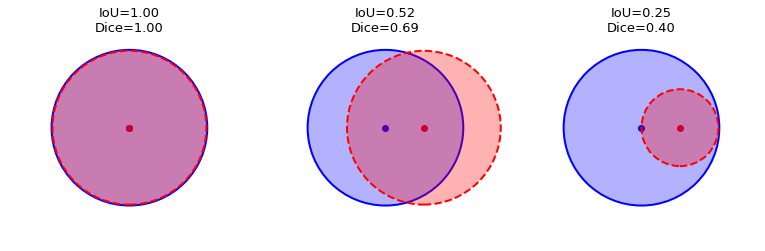


There exists many more losses which I will explore in other notebooks, many of which are mentioned in really nice survey [2].


### Multiclass
Important consideration of each of this losses is that most often they are only mentioned for binary classes. Most likely however, we will deal with multiclass prediction problem. A way to deal with it, is to one hot encode our predictions, and calculate DICE or IoU for each of the classes. Then calculate the mean of them (or weighted mean) to get the final score.

### great articles / references : 
- [1]https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
- [2]https://arxiv.org/pdf/2006.14822.pdf
- [3]https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b
- [4]https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou/276144#276144

In [20]:
# dice loss
# awesome implementation for DICE can be found here
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py
def dice_coeff(inp : Tensor, tgt : Tensor, eps=cfg.EXTRA_LOSS_EPS):
    sum_dim = (-1, -2, -3)

    # calculation of intersection   
    inter = 2 *(inp * tgt).sum(dim=sum_dim)

    # calculate the sum of |inp| + |tgt|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)

    # calcaute the dice    
    dice = (inter + eps) / (sets_sum + eps)

    # average the dice of classwise
    return dice.mean()

def multiclass_dice_coeff(input: Tensor, target: Tensor, eps: float = cfg.EXTRA_LOSS_EPS):
    return dice_coeff(input.flatten(0, 1), target.flatten(0, 1), eps)

def dice_loss(input: Tensor, target: Tensor):
    # Dice loss (objective to minimize) between 0 and 1
    return 1 - multiclass_dice_coeff(input, target)

def IoU_coeff(inp : Tensor, tgt : Tensor, eps = 1e-6):
    sum_dim = (-1, -2, -3)
    
    # Intersection term  |A ^ B|
    inter = (inp * tgt).sum(dim=sum_dim)
    
    # sum of |A| + |B|
    sets_sum = inp.sum(dim=sum_dim) + tgt.sum(dim=sum_dim)
    sets_sum = torch.where(sets_sum == 0, inter, sets_sum)
    
    # IoU = |A ^ B| / |A \/ B| = |A ^ B| / (|A| + |B| - |A^B|)
    return (inter + eps) / (sets_sum - inter + eps)

def IoU_loss(inp : Tensor, tgt : Tensor):
    return 1 - IoU_coeff(inp.flatten(0,1), tgt.flatten(0,1))

## 3. Model Evaluation and Training 
We will now write a generic function to evaluate and train semantic segmentation models. We will later use these functions to train specific semantic segmentation models.

### Model Evaluation

In [21]:
def evaluate_model(model, val_dataloader, epoch, epochs, criterion,
                   with_dice_loss=True, with_IoU_loss=False):
    global epoch_to_fig 
    val_loss = 0
    val_dice = 0
    val_IoU = 0
    with tqdm(val_dataloader, desc=f"Epoch {epoch}/{epochs} ; val Loss 0") as pbar:
        model.eval()
        examples_so_far = 0
        for i, batch in enumerate(val_dataloader):
            images, true_masks = batch[0], batch[1]
                
            images = images.to(device)
            true_masks = true_masks.to(device).long()                
                
            # predictions
            masks_pred = model(images)
            
            loss = criterion(masks_pred, true_masks)
            val_loss += loss.item() * images.shape[0]
            examples_so_far += images.shape[0]

            dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                             F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_dice_loss:
                loss += dice
            val_dice += images.shape[0] * (1.-dice.item())
                
            IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                           F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
            if with_IoU_loss:
                loss += IoU
            val_IoU += images.shape[0] * (1.-IoU.item())
            
            pbar.update(1)
                
            descr = f"Epoch {epoch}/{epochs} ; val Loss {round(val_loss / examples_so_far ,3)}, val IoU : {round(val_IoU / examples_so_far ,3)}, val Dice : {round(val_dice / examples_so_far ,3)}"               
            pbar.set_description(descr)

    eval_summary = {}
    eval_summary["validation_loss"] = val_loss / examples_so_far
    eval_summary["validation_DICE_coefficient"] = val_dice / examples_so_far
    eval_summary["validation_IoU_coefficient"] = val_IoU / examples_so_far

    return eval_summary

### Model Training

In [22]:
def train_model(model, device, train_dataloader,
                val_dataloader, epochs=10, lr=1e-4, update_pb_every_batch = 1,
                with_dice_loss=True, with_IoU_loss=False):
    global global_step
    
    # setup the optimizer, loss, learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    criterion = nn.CrossEntropyLoss()
    
    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

    returned_data = []

    for epoch in range(1, epochs + 1):
        
        training_loss = 0
        training_dice = 0
        training_IoU = 0
        with tqdm(train_dataloader, desc=f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss,3)}") as pbar:
            model.train()
            optimizer.zero_grad()
            examples_so_far = 0
            for i,batch in enumerate(train_dataloader):
                optimizer.zero_grad()
                images, true_masks = batch[0], batch[1]
                
                images = images.to(device)
                true_masks = true_masks.to(device).long()
                                
                masks_pred = model(images)
                
                loss = criterion(masks_pred, true_masks)
                if with_dice_loss:
                    dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += dice
                    training_dice += images.shape[0] * (1.-dice.item())
                
                if with_IoU_loss:
                    IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
                    loss += IoU
                    training_IoU += images.shape[0] * (1.-IoU.item())
                
                # Backward and optimize
                #loss.backward()
                accelerator.backward(loss)
                optimizer.step()
                
                global_step += 1
                training_loss += images.shape[0] * loss.item()
                examples_so_far += images.shape[0]

                pbar.update(1)
                if i % update_pb_every_batch == 0:
                    descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}"        
                    if with_dice_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg DICE : {round(training_dice / examples_so_far ,3)}"   
                    elif with_IoU_loss:
                        descr = f"Epoch {epoch}/{epochs} ; training Loss {round(training_loss / examples_so_far ,3)}, avg IoU : {round(training_IoU / examples_so_far ,3)}"
                    
                    pbar.set_description(descr)
        
        epoch_summary = {}
        epoch_summary["training_loss"] = training_loss / examples_so_far
        if with_dice_loss:
            epoch_summary["training_DICE_coefficient"] = training_dice / examples_so_far
        if with_IoU_loss:
            epoch_summary["training_IoU_coefficient"] = training_IoU / examples_so_far


        val_summary = evaluate_model(model, val_dataloader, epoch, epochs, criterion, with_dice_loss=with_dice_loss, with_IoU_loss=with_IoU_loss)
        epoch_summary = {**epoch_summary, **val_summary}
        returned_data.append(epoch_summary)

    return returned_data

### Model Inference and Visualization

In [23]:
def show_inference(batch, predictions):

    batch_size = batch[0].shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(6, 2.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.05, wspace=0)

    for i in range(batch_size):
        img, mask = batch[0][i], batch[1][i]  

        axes[i, 0].imshow(decode_image(img.permute(1,2, 0)))
        axes[i,0].set_xticks([])
        axes[i,0].set_yticks([])
        if i == 0:
            axes[i, 0].set_title("Input Image")

        axes[i, 1].imshow(mask, cmap='magma')
        axes[i,1].set_xticks([])
        axes[i,1].set_yticks([])
        if i == 0:
            axes[i, 1].set_title("True Mask")

        predicted = predictions[i]
        predicted = predicted.permute(1, 2, 0)
        predicted = torch.argmax(predicted, dim=2)

        axes[i, 2].imshow(predicted.cpu(), cmap='magma')
        axes[i, 2].set_xticks([])
        axes[i, 2].set_yticks([])
        if i == 0:
            axes[i, 2].set_title("Predicted Mask")



### Plot the losses/coefficients

In [24]:
def plot_losses_coeffs(training_val_summary):

    if cfg.SNS_STYLE is not None:
        sns.set(style=cfg.SNS_STYLE)

    training = defaultdict(list)
    validation = defaultdict(list)

    m = 0

    for epoch_summary in training_val_summary:
        keys = list(epoch_summary.keys())

        training_keys = [k for k in keys if k.startswith("training")]
        for k in training_keys:
            training[k[len("training")+1:]].append(epoch_summary[k])

        val_keys = [k for k in keys if k.startswith("validation")]
        for k in val_keys:
            validation[k[len("validation")+1:]].append(epoch_summary[k])

    fig, axes = plt.subplots(len(validation.keys()), 1, figsize=(10, 10), sharex=True)

    for i,k in enumerate(validation.keys()):

        if k in training:
            axes[i].plot(training[k], marker='o', linestyle='--', label="training", linewidth=3)


        if validation[k][-1] > validation[k][0]:
            best_idx = np.argmax(validation[k])
        else:
            best_idx = np.argmin(validation[k])
        
        best = validation[k][best_idx]

        axes[i].set_title(f"{k} (validation best : {round(best, 4)})", fontsize=14, fontweight="bold")
        axes[i].plot(validation[k], label="validation", marker='o', linestyle='--', linewidth=3)

        axes[i].plot([0, best_idx], [best, best], linewidth=2, linestyle="--", color='black', alpha=0.5)
        m = max(m, len(validation[k]))
        axes[i].legend()

    axes[-1].set_xticks(list(range(0, m)))
    axes[-1].set_xticklabels(list(range(1, m + 1)))
    sns.set(style="white")

## 4. Model Definition: Unet

### Description

Unet is one of the most popular architectures for semantic segmentation, which won multiple semantic segmentation competitions for medical images [1]. This architecture was introduced in the paper **\"U-Net: Convolutional Networks for Biomedical Image Segmentation\"**. The most likely reason why Unet is popular is that it works well and the architecture itself is easy to code and intuitive. It is a fully convolutional neural network (the main computational operation is 2D convolution, with no Dense layers) and the original architecture is represented in figure a). The architecture is nicely symmetric and intuitive. We start with an input image and apply convolutions twice. we then save this output, and downscale (using max-pooling layer), which results in an image of size $(\frac{h}{2}, \frac{w}{2})$. We continue to follow this pattern until we reach a bottleneck layer (bottom-middle layer). After applying 2 convolutions, we apply deconvolution (which will upscale the image, from $(h,w) \rightarrow (2h, 2w)$). There a crucial step is done: the outputs from applying the convolutions (left-side) are concatenated with the deconvolutions (the upsampling). This is done in order to localize high resolution, and convolutions can learn to assemble a more precise output based on this information [1]. An important property of this architecture is that upsampling layers has also many channels, which should allow propagating information context properly. The architecture is visualized as shown below.

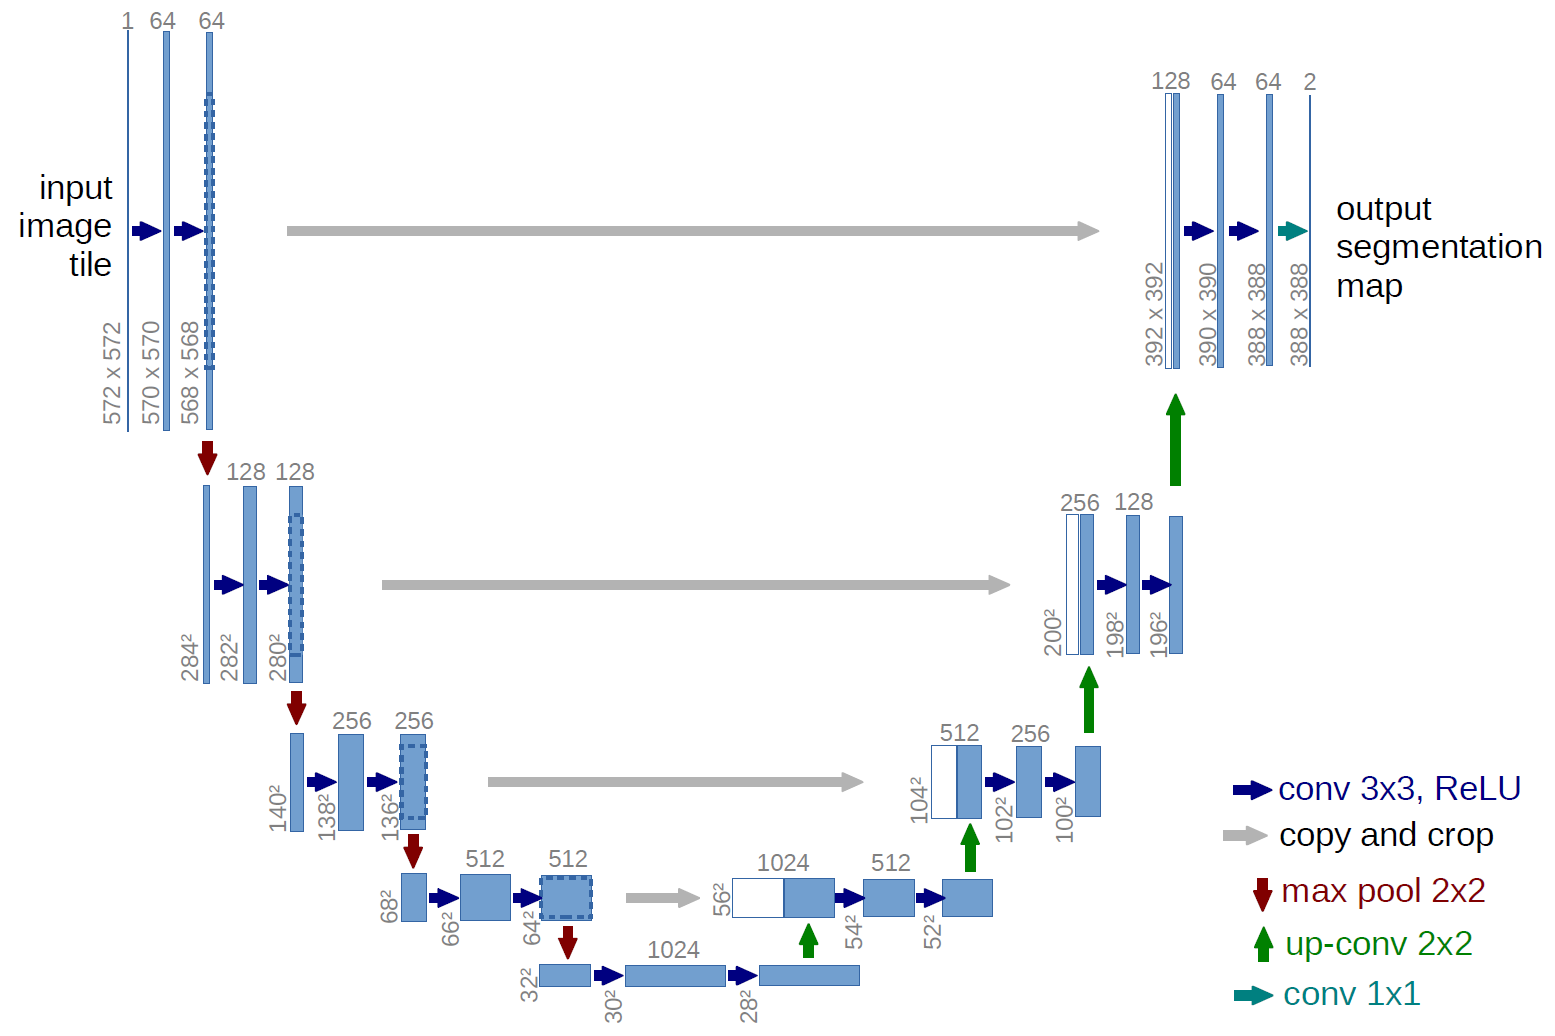

Some other notes :
- Unet paper also introduces a data augmentation for semantic segmentation. Data augmentation is a very popular technique to make the network generalize better, by perturbing or modifying the dataset. It also allows training networks with smaller datasets (as we constantly perturb the data). They achieve that by introducing **elastic deformations**.

[1] https://arxiv.org/abs/1505.04597

### Network Architecture

In [25]:
class ConvBlock(nn.Module):
    """apply twice convolution followed by batch normalization and relu. Preserves the width and height of input"""
    
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.cn1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.activ1 = nn.ReLU(inplace=True)
        self.cn2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.activ2 = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.cn1(x)
        x = self.bn1(x)
        x = self.activ1(x)
        x = self.cn2(x)
        x = self.bn2(x)
        return self.activ2(x)

class DownScale(nn.Module):
    """Downscaling with maxpool then ConvBlock, transforming an input with (h, w, in_channels) to (h/2, w/2, out_channels)"""
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.block = ConvBlock(in_channels, out_channels)
    
    def forward(self, x):
        x = self.pool(x)
        x = self.block(x)
        return x
 

class UpScale(nn.Module):
    """apply upscaling and then convolution block transforming an input with (h,w,in_channels) to (2h, 2w, out_channels).
       Forward function also simplifies Unet propagation by taking two inputs : first one from constantly propagating (from upscaling)
       and the second one, which is the output from applying Downscale (first input is upscaled, then concatenated with second)"""
    
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is (batch, channel, height, width)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class Unet(nn.Module):
    def __init__(self, n_channels, n_classes, start=32, bilinear=False):
        super(Unet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = ConvBlock(n_channels, start)
        self.down1 = DownScale(start, 2*start)
        self.down2 = DownScale(2*start, 4*start)
        self.down3 = DownScale(4*start, 8*start)
        
        factor = 2 if bilinear else 1
        self.down4 = DownScale(8*start, 16*start // factor)
        
        self.up1 = UpScale(16*start, 8*start // factor, bilinear)
        self.up2 = UpScale(8*start, 4*start // factor, bilinear)
        self.up3 = UpScale(4*start, 2*start // factor, bilinear)
        self.up4 = UpScale(2*start, start, bilinear)
        self.outc = nn.Conv2d(start, n_classes, kernel_size=1)
    
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    

number_of_classes = len(set(name_to_category.values()))
summary(Unet(3, number_of_classes), input_data=eval_batch_data[0])

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [8, 8, 128, 128]          --
├─ConvBlock: 1-1                         [8, 32, 128, 128]         --
│    └─Conv2d: 2-1                       [8, 32, 128, 128]         864
│    └─BatchNorm2d: 2-2                  [8, 32, 128, 128]         64
│    └─ReLU: 2-3                         [8, 32, 128, 128]         --
│    └─Conv2d: 2-4                       [8, 32, 128, 128]         9,216
│    └─BatchNorm2d: 2-5                  [8, 32, 128, 128]         64
│    └─ReLU: 2-6                         [8, 32, 128, 128]         --
├─DownScale: 1-2                         [8, 64, 64, 64]           --
│    └─MaxPool2d: 2-7                    [8, 32, 64, 64]           --
│    └─ConvBlock: 2-8                    [8, 64, 64, 64]           --
│    │    └─Conv2d: 3-1                  [8, 64, 64, 64]           18,432
│    │    └─BatchNorm2d: 3-2             [8, 64, 64, 64]           128
│    │

## 5. Model Training and Visualization

We will now train the model on our dataset and evaluate the results.

### Model Training

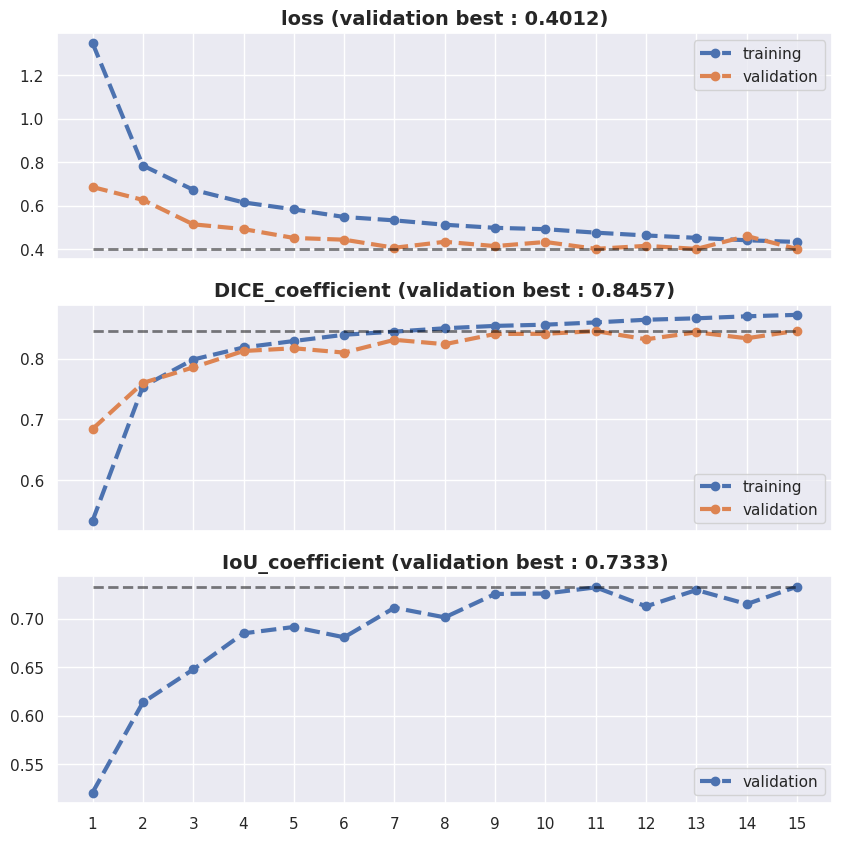

In [26]:
device = "cuda"
model = Unet(3, number_of_classes)
model = model.to(device)

Unet_training_val_summary = train_model(model, device, train_dataloader, val_dataloader,
                                        lr=3e-4, epochs=cfg.SINGLE_NETWORK_TRAINING_EPOCHS, update_pb_every_batch=10)

clear_output(True)
plot_losses_coeffs(Unet_training_val_summary)


### Model Inference (Show results)

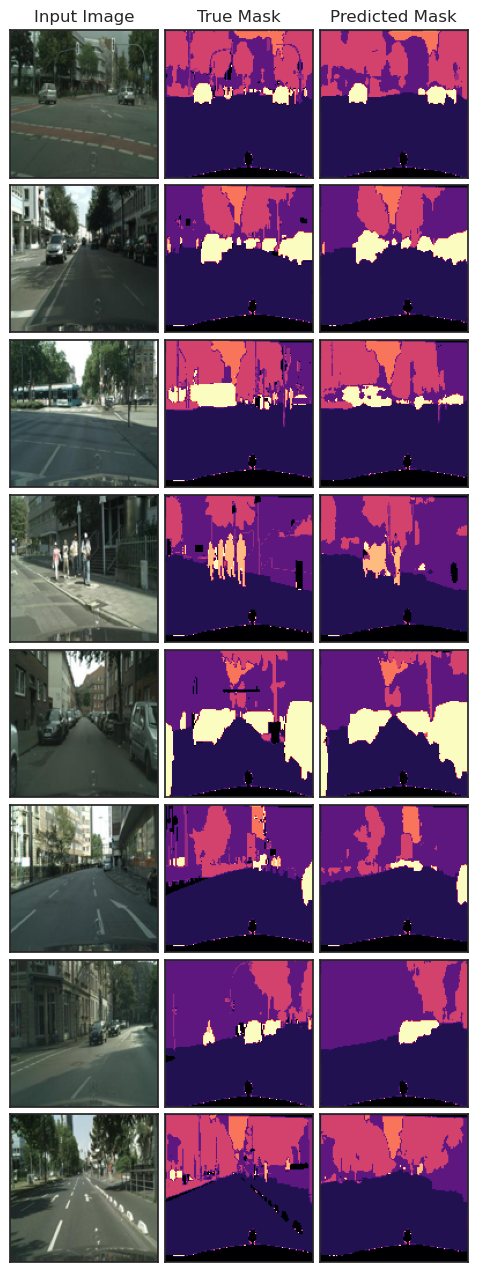

In [27]:
batch = next(iter(val_dataloader))
predictions = model(batch[0].to(device))
show_inference(batch, predictions)

-----
## 6. Comparison of how loss affects the prediction (CE and DICE)

In this section, we show simple visualization on prediction of these networks looks like when we prioritze differently CrossEntropy and DICE loss (a sweep of $\beta \in [0,1]$ for loss $\beta \cdot CrossEntropy(Y_{true}, Y_{pred}) + (1 - \beta) \cdot DICE(Y_{true}, Y_{pred})$). 

### Training / Eval for CE vs DICE comparison

In [28]:
def train_model_CE_DICE(model, device, train_dataloader,
                val_dataloader, Beta=0., epochs=10, lr=1e-4, update_pb_every_batch = 1):
    global global_step
    
    # setup the optimizer, loss, learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    cross_entropy = nn.CrossEntropyLoss()
    
    model, optimizer, train_dataloader = accelerator.prepare(model, optimizer, train_dataloader)

    returned_data = []

    for epoch in range(1, epochs + 1):
        
        training_loss = 0
        training_dice = 0
        training_CE = 0
        
        model.train()
        optimizer.zero_grad()
        examples_so_far = 0
        for i,batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            images, true_masks = batch[0], batch[1]
                
            images = images.to(device)
            true_masks = true_masks.to(device).long()
                                
            masks_pred = model(images)
                
            CE   = cross_entropy(masks_pred, true_masks)
            dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                              F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            loss = Beta * CE + (1. - Beta) * dice
            training_dice += images.shape[0] * (1.-dice.item())
            training_CE += images.shape[0] * CE.item()
                
            # Backward and optimize
            #loss.backward()
            accelerator.backward(loss)
            optimizer.step()
                
            global_step += 1
            training_loss += images.shape[0] * loss.item()
            examples_so_far += images.shape[0]
        
        epoch_summary = {}
        epoch_summary["training_loss"] = training_loss / examples_so_far
        epoch_summary["training_CE"] = training_CE / examples_so_far
        epoch_summary["training_DICE_coefficient"] = training_dice / examples_so_far
        
        val_summary = evaluate_model_CE_DICE(model, val_dataloader, epoch, epochs)
        epoch_summary = {**epoch_summary, **val_summary}
        returned_data.append(epoch_summary)

    return returned_data


def evaluate_model_CE_DICE(model, val_dataloader, epoch, epochs):
    global epoch_to_fig 
    val_CE = 0
    val_dice = 0
    val_IoU = 0
    cross_entropy = nn.CrossEntropyLoss()

    model.eval()
    examples_so_far = 0
    for i, batch in enumerate(val_dataloader):
        images, true_masks = batch[0], batch[1]
                
        images = images.to(device)
        true_masks = true_masks.to(device).long()                
                
        # predictions
        masks_pred = model(images)
            
        loss = cross_entropy(masks_pred, true_masks)
        val_CE += loss.item() * images.shape[0]
        examples_so_far += images.shape[0]

        dice = dice_loss(F.softmax(masks_pred, dim=1).float(),
                             F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
        val_dice += images.shape[0] * (1.-dice.item())
                
        IoU = IoU_loss(F.softmax(masks_pred, dim=1).float(),
                           F.one_hot(true_masks.long(), number_of_classes).permute(0, 3, 1, 2).float())
            
        val_IoU += images.shape[0] * (1.-IoU.item())

    eval_summary = {}
    eval_summary["validation_CE"] = val_CE / examples_so_far
    eval_summary["validation_DICE_coefficient"] = val_dice / examples_so_far
    eval_summary["validation_IoU_coefficient"] = val_IoU / examples_so_far

    return eval_summary

### CE vs DICE comparison plotting/training utils

In [29]:
def plot_summaries_preds(summaries, preds):
    true_val = eval_batch_data[1].permute(1, 2, 0)  
    images = [true_val] + [*preds]
    
    batch_size = images[0].shape[-1]
    
    fig, axes = plt.subplots(batch_size, len(images), figsize=(18, 2.*batch_size), squeeze=True, sharey=True, sharex=True)
    fig.subplots_adjust(hspace=0.0, wspace=0)

    for i in range(len(images)):
        for j in range(batch_size):

            axes[j, i].imshow(images[i][:,:,j].cpu())    
            axes[j,i].set_xticks([])
            axes[j,i].set_yticks([])
            if i == 0 and j == 0:
                summary = summaries[i]
                axes[0,0].set_title(f"True Mask")
    
            elif i == 1 and j == 0:
                axes[j,i].set_title(f"Sum of DICE+CE\nCE={round(summary['VAL_LOSS'],2)},DICE={round(summary['VAL_DICE'],2)}")
                
            elif j == 0:
                summary = summaries[i-1]
                axes[j,i].set_title(f"Beta={round(summary['BETA'], 2)}\nCE={round(summary['VAL_CE'],2)},DICE={round(summary['VAL_DICE'],2)}")


def get_summaries_preds_for_comparison(delta_Beta, model_ref, model_params, model_mixed, summary_mixed, epochs=25, lr=3e-4):

    summaries = []
    predictions = []
    device = "cuda"

    d = defaultdict(list)
    for x in summary_mixed:
        for k,v in x.items():
            d[k].append(v)
                
    LOSS, DICE, V_LOSS, V_DICE, V_IOU = d["training_loss"][-1], d["training_DICE_coefficient"][-1], d["validation_loss"][-1], d["validation_DICE_coefficient"][-1], d["validation_IoU_coefficient"][-1]
    summaries.append({"LOSS" : LOSS, "DICE" : DICE, "VAL_LOSS" : V_LOSS, "VAL_DICE" : V_DICE, "VAL_IOU" : V_IOU})
    predictions.append(torch.argmax(model_mixed(eval_batch_data[0].to(device)), dim=1).permute(1, 2, 0))

    for Beta in np.arange(0, 1. + 1e-9, delta_Beta):
        start = time()
        model = model_ref(**model_params)
        model = model.to(device)
        summary = train_model_CE_DICE(model, device, train_dataloader, val_dataloader, Beta=Beta,
                                                lr=lr, epochs=epochs, update_pb_every_batch=10)
        
        d = defaultdict(list)
        for x in summary:
            for k,v in x.items():
                d[k].append(v)
                
        CE, DICE, V_CE, V_DICE, V_IOU = d["training_CE"][-1], d["training_DICE_coefficient"][-1], d["validation_CE"][-1], d["validation_DICE_coefficient"][-1], d["validation_IoU_coefficient"][-1]

        summaries.append({"BETA" : Beta,  "CE" : CE, "DICE" : DICE, "VAL_CE" : V_CE, "VAL_DICE" : V_DICE, "VAL_IOU" : V_IOU})
        predictions.append(torch.argmax(model(eval_batch_data[0].to(device)), dim=1).permute(1, 2, 0))
        print(f"[{int(time() - start)}s] Model with Beta={Beta} finished with training CE : {CE}, training DICE : {DICE}, validation CE : {V_CE}, Validation DICE : {V_DICE}, Validation IOU : {V_IOU}")


    return summaries, predictions


In [30]:
# LONG COMPUTATION !

summaries, preds = get_summaries_preds_for_comparison(cfg.DELTA_BETA, Unet, {"n_channels" : 3, "n_classes" : number_of_classes},
                                                      model_mixed=model, summary_mixed=Unet_training_val_summary, epochs=cfg.CE_VS_DICE_EVAL_EPOCHS)

plot_summaries_preds(summaries, preds)

[339s] Model with Beta=0.0 finished with training CE : 1.0542182920560115, training DICE : 0.8891943438313589, validation CE : 1.233279878616333, Validation DICE : 0.8734372601509094, Validation IOU : 0.7761480140686036
[337s] Model with Beta=0.2 finished with training CE : 0.35198917410954705, training DICE : 0.8853055934144669, validation CE : 0.4436590919494629, Validation DICE : 0.8585998163223266, Validation IOU : 0.7531976957321167
[337s] Model with Beta=0.4 finished with training CE : 0.3129064508846828, training DICE : 0.8762501526079258, validation CE : 0.40631360387802123, Validation DICE : 0.8513424763679505, Validation IOU : 0.7421743535995483
[340s] Model with Beta=0.6000000000000001 finished with training CE : 0.2985093000456065, training DICE : 0.8694114183978874, validation CE : 0.40525009274482726, Validation DICE : 0.8486879696846008, Validation IOU : 0.7379473457336426


KeyboardInterrupt: 

We observe that the DICE loss gives superior results than a simple cross-entropy loss

# Excercise
1. You can compare the result of DICE vs IOU loss.

---
# Useful Resources for Semantic Segmentation
1. https://github.com/open-mmlab/mmsegmentation
2. https://github.com/qubvel/segmentation_models.pytorch